In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import pandas as pd
import plotly.express as px
import random
import json
from sklearn.preprocessing import MinMaxScaler

sys.path.append(os.path.abspath('../src/'))
from ActivationFunctions import *
from NeuralNetwork import *
from MyUtils import *

In [2]:
tr_df = pd.read_csv('../data/monks_csv/monks_tr_3.csv', index_col=0)
len_training = len(tr_df)
val_df = pd.read_csv('../data/monks_csv/monks_ts_3.csv', index_col=0) # test in realtà ma va be
len_validation = len(val_df)
len_dataset = len_training + len_validation
val_df.sample(5, random_state=RANDOM_STATE)

,input_1,input_2,input_3,input_4,input_5,input_6,output_1
173,2,1,2,1,3,2,1
91,1,2,2,3,2,2,1
105,1,3,1,2,1,2,0
431,3,3,2,3,4,2,0
389,3,3,1,1,3,2,1


In [3]:
def OHE(df):
    OHE = pd.get_dummies(df, columns=['input_'+str(i) for i in range(1, 7)])
    OHE = OHE.set_axis(['output_1'] + ['input_' + str(i) for i in range(1, len(OHE.columns))], axis=1)
    cols = OHE.columns.tolist()
    cols = cols[1:] + cols[:1]
    OHE = OHE[cols]
    return OHE

In [4]:
tr_df_OHE = OHE(tr_df)
tr_df_OHE.sample(5, random_state=RANDOM_STATE)

,input_1,input_2,input_3,input_4,input_5,input_6,input_7,input_8,input_9,input_10,input_11,input_12,input_13,input_14,input_15,input_16,input_17,output_1
93,0,0,1,1,0,0,1,0,0,0,1,0,0,0,1,0,1,0
16,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1
17,1,0,0,0,1,0,1,0,1,0,0,0,0,1,0,1,0,1
95,0,0,1,1,0,0,0,1,0,1,0,0,0,1,0,0,1,1
35,1,0,0,0,0,1,1,0,1,0,0,0,1,0,0,1,0,0


In [5]:
val_df_OHE = OHE(val_df)
val_df_OHE.sample(5, random_state=RANDOM_STATE)

,input_1,input_2,input_3,input_4,input_5,input_6,input_7,input_8,input_9,input_10,input_11,input_12,input_13,input_14,input_15,input_16,input_17,output_1
173,0,1,0,1,0,0,0,1,1,0,0,0,0,1,0,0,1,1
91,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,1
105,1,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,1,0
431,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0
389,0,0,1,0,0,1,1,0,1,0,0,0,0,1,0,0,1,1


From monk database:

Attribute information:
1. class: 0, 1 
2. a1:    1, 2, 3
3. a2:    1, 2, 3
4. a3:    1, 2
5. a4:    1, 2, 3
6. a5:    1, 2, 3, 4
7. a6:    1, 2
8. Id:    (A unique symbol for each instance)

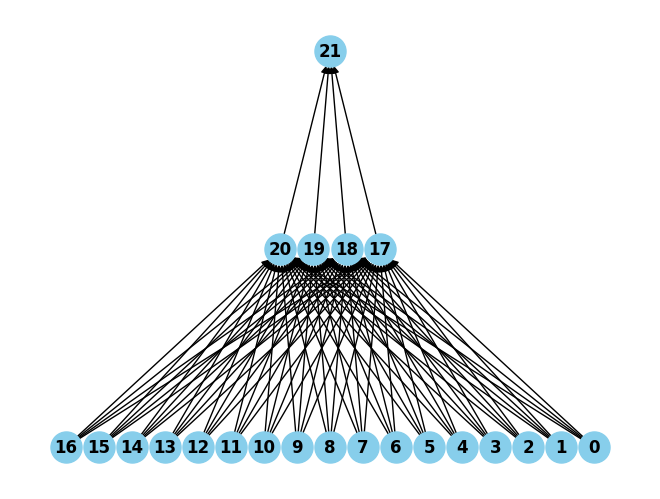

In [6]:
TR_INPUT = len(tr_df_OHE.columns) - 1
TR_OUTPUT = 1
hidden_len = 4
topology = create_stratified_topology([TR_INPUT,hidden_len,TR_OUTPUT], 
                                      [[None,[]]]*TR_INPUT + [['sigmoid', [1]]]*hidden_len + [['sigmoid', [1]]])
NeuralNetwork.display_topology(topology)

In [7]:
NN = NeuralNetwork(topology, -0.75, 0.75, False, RANDOM_STATE)

In [8]:
training_set = tr_df_OHE.values
validation_set = val_df_OHE.values
metrics = [ErrorFunctions.mean_squared_error, ] #ErrorFunctions.mean_euclidean_error, 

batch_size = int(len_training/10)
max_epochs = 1000

error_decrease_tolerance = 0.01
patience = 10
min_epochs = 250

lambda_tikhonov = 0.0001
alpha_momentum = 0.9
learning_rate = 0.5/batch_size
# beacause of the momentum is used the learning rate needs to be a little less?!?!?

collect_datas = True
collect_datas_batch = False # per il momento. molto costoso!!!! False di default
verbose = True

stats = NN.train(training_set, validation_set, batch_size, max_epochs, error_decrease_tolerance, patience, min_epochs, 
                   learning_rate, lambda_tikhonov, alpha_momentum, metrics, collect_datas, collect_datas_batch, verbose)

starting values:  {'training_set_len': 122, 'minibatch_size': 12, 'max_epochs': 1000, 'error_decrease_tolerance': 0.01, 'patience': 10, 'min_epochs': 250, 'learning_rate': 0.041666666666666664, 'lambda_tikhonov': 0.0001, 'alpha_momentum': 0.9, 'epochs': 0, 'total_train_time': datetime.timedelta(0), 'mean_epoch_train_time': 0, 'units_weights': {20: [], 19: [], 18: [], 17: [], 21: []}, 'units_weights_batch': {20: [], 19: [], 18: [], 17: [], 21: []}, 'training_mean_squared_error': [], 'validation_mean_squared_error': [], 'training_batch_mean_squared_error': [], 'validation_batch_mean_squared_error': []}
[1/1000] tr time: 0:00:00.043012 | mean_squared_error: tr=0.28700711800882295 val=0.2754066194609643 | 
[2/1000] tr time: 0:00:00.039325 | mean_squared_error: tr=0.27502652626982527 val=0.26580391627057226 | 
[3/1000] tr time: 0:00:00.039069 | mean_squared_error: tr=0.26322332495229955 val=0.256959265867097 | 
[4/1000] tr time: 0:00:00.044178 | mean_squared_error: tr=0.2539918395022778 val

In [9]:
tr_predictions = NN.predict_array(training_set[:,:TR_INPUT])
val_predictions = NN.predict_array(validation_set[:,:TR_INPUT])

In [10]:
pd.options.mode.chained_assignment = None
prediction_col = ['prediction_1']#, 'prediction_2', 'prediction_3']
for col in prediction_col:
    tr_df[prediction_col] = np.array([[1] if x > 0.5 else [0] for x in tr_predictions])
    tr_df[col + '_err'] = (tr_df[col] - tr_df['output_' + col[-1]])**2
    

In [11]:
tr_df['prediction_1_err'].max()

1

In [12]:
tr_df.sample(5, random_state=RANDOM_STATE)

,input_1,input_2,input_3,input_4,input_5,input_6,output_1,prediction_1,prediction_1_err
93,3,1,1,3,4,2,0,0,0
16,1,1,2,3,3,2,1,1,0
17,1,2,1,1,3,1,1,1,0
95,3,1,2,2,3,2,1,1,0
35,1,3,1,1,2,1,0,0,0


In [13]:
val_df[prediction_col] = val_predictions
for col in prediction_col:
    val_df[prediction_col] = np.array([[1] if x > 0.5 else [0] for x in val_predictions])
    val_df[col + '_err'] = (val_df[col] - val_df['output_' + col[-1]])**2
    

In [14]:
val_df.sample(5, random_state=RANDOM_STATE)

,input_1,input_2,input_3,input_4,input_5,input_6,output_1,prediction_1,prediction_1_err
173,2,1,2,1,3,2,1,1,0
91,1,2,2,3,2,2,1,1,0
105,1,3,1,2,1,2,0,0,0
431,3,3,2,3,4,2,0,0,0
389,3,3,1,1,3,2,1,1,0


In [15]:
print('training accuracy =', (tr_df['output_1'] == tr_df['prediction_1']).sum() / len(tr_df))
print('validation accuracy =', (val_df['output_1'] == val_df['prediction_1']).sum() / len(val_df))

training accuracy = 0.9508196721311475
validation accuracy = 0.9675925925925926


In [16]:
print('misclassified =', (tr_df['output_1'] != tr_df['prediction_1']).sum(), 'su', len(tr_df))
print('misclassified =', (val_df['output_1'] != val_df['prediction_1']).sum(), 'su', len(val_df))

misclassified = 6 su 122
misclassified = 14 su 432


In [17]:
for key in list(stats.keys())[:12]:
    print(key, ':', stats[key])

training_set_len : 122
minibatch_size : 12
max_epochs : 1000
error_decrease_tolerance : 0.01
patience : 10
min_epochs : 250
learning_rate : 0.041666666666666664
lambda_tikhonov : 0.0001
alpha_momentum : 0.9
epochs : 1000
total_train_time : 0:00:40.324386
mean_epoch_train_time : 0:00:00.040324


In [18]:
for met in metrics:
    print('last training ' + met.__name__ + ' :', stats['training_' + met.__name__][-1])
    print('last validation ' + met.__name__ + ' :', stats['training_' + met.__name__][-1])

last training mean_squared_error : 0.059013853168954404
last validation mean_squared_error : 0.059013853168954404


In [19]:
for met in metrics:
    print('last training ' + met.__name__ + ' :', stats['training_' + met.__name__][-1])
    print('last validation ' + met.__name__ + ' :', stats['training_' + met.__name__][-1])

last training mean_squared_error : 0.059013853168954404
last validation mean_squared_error : 0.059013853168954404


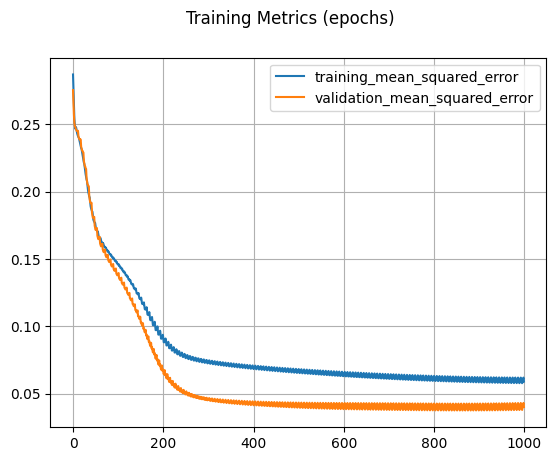

In [20]:
if len(metrics) > 1:
    fig, ax = plt.subplots(1, len(metrics), figsize=(10, 5))
    plt.suptitle('Training Metrics (epochs)')
    for i in range(len(metrics)):
        multy_plot([stats['training_' + metrics[i].__name__], stats['validation_' + metrics[i].__name__]], 
                ['training_' + metrics[i].__name__, 'validation_' + metrics[i].__name__],
                ax=ax[i])
else:
    plt.suptitle('Training Metrics (epochs)')
    multy_plot([stats['training_' + metrics[0].__name__], stats['validation_' + metrics[0].__name__]], 
                ['training_' + metrics[0].__name__, 'validation_' + metrics[0].__name__])

In [21]:

'''plt.suptitle('Training Metrics (epochs)')
for i in range(len(metrics)):
    multy_plot([stats_0['training_' + metrics[i].__name__], stats_0['validation_' + metrics[i].__name__]] + 
               [stats_1['training_' + metrics[i].__name__], stats_1['validation_' + metrics[i].__name__]] +
               [stats_2['training_' + metrics[i].__name__], stats_2['validation_' + metrics[i].__name__]] +
               [stats_3['training_' + metrics[i].__name__], stats_3['validation_' + metrics[i].__name__]],
            ['tr_0.0', 'val_0.0', 'tr_0.25', 'val_0.25', 'tr_0.5', 'val_0.5', 'tr_0.75', 'val_0.75', 'tr_0.95', 'val_0.95',], 
            title='Training Metrics (epochs)')'''

"plt.suptitle('Training Metrics (epochs)')\nfor i in range(len(metrics)):\n    multy_plot([stats_0['training_' + metrics[i].__name__], stats_0['validation_' + metrics[i].__name__]] + \n               [stats_1['training_' + metrics[i].__name__], stats_1['validation_' + metrics[i].__name__]] +\n               [stats_2['training_' + metrics[i].__name__], stats_2['validation_' + metrics[i].__name__]] +\n               [stats_3['training_' + metrics[i].__name__], stats_3['validation_' + metrics[i].__name__]],\n            ['tr_0.0', 'val_0.0', 'tr_0.25', 'val_0.25', 'tr_0.5', 'val_0.5', 'tr_0.75', 'val_0.75', 'tr_0.95', 'val_0.95',], \n            title='Training Metrics (epochs)')"

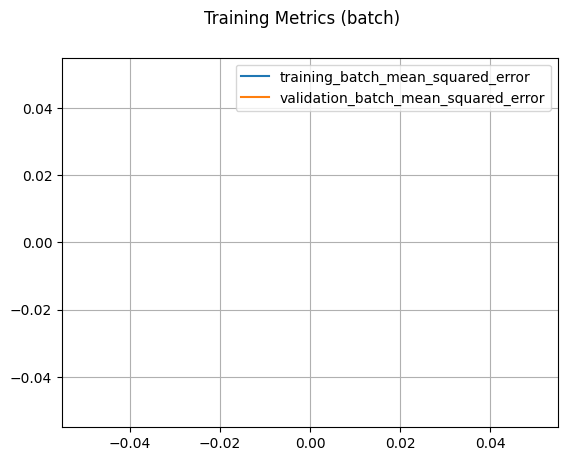

In [22]:
if len(metrics) > 1:
    fig, ax = plt.subplots(1, len(metrics), figsize=(10, 5))
    plt.suptitle('Learning Curve (batch)')
    for i in range(len(metrics)):
        multy_plot([stats['training_batch_' + metrics[i].__name__], stats['validation_batch_' + metrics[i].__name__]], 
                ['training_batch_' + metrics[i].__name__, 'validation_batch_' + metrics[i].__name__],
                ax=ax[i])
    plt.show()
else:
    plt.suptitle('Training Metrics (batch)')
    multy_plot([stats['training_batch_' + metrics[0].__name__], stats['validation_batch_' + metrics[0].__name__]], 
                ['training_batch_' + metrics[0].__name__, 'validation_batch_' + metrics[0].__name__])

In [23]:
'''plt.suptitle('Training Metrics (epochs)')
for i in range(len(metrics)):
    multy_plot([stats_0['training_batch_' + metrics[i].__name__], stats_0['validation_batch_' + metrics[i].__name__]] + 
               [stats_1['training_batch_' + metrics[i].__name__], stats_1['validation_batch_' + metrics[i].__name__]] +
               [stats_2['training_batch_' + metrics[i].__name__], stats_2['validation_batch_' + metrics[i].__name__]] +
               [stats_3['training_batch_' + metrics[i].__name__], stats_3['validation_batch_' + metrics[i].__name__]] + 
               [stats_4['training_batch_' + metrics[i].__name__], stats_4['validation_batch_' + metrics[i].__name__]],
            ['tr_0.0', 'val_0.0', 'tr_0.25', 'val_0.25', 'tr_0.5', 'val_0.5', 'tr_0.75', 'val_0.75', 'tr_0.95', 'val_0.95',], 
            title='Training Metrics (epochs)')'''

"plt.suptitle('Training Metrics (epochs)')\nfor i in range(len(metrics)):\n    multy_plot([stats_0['training_batch_' + metrics[i].__name__], stats_0['validation_batch_' + metrics[i].__name__]] + \n               [stats_1['training_batch_' + metrics[i].__name__], stats_1['validation_batch_' + metrics[i].__name__]] +\n               [stats_2['training_batch_' + metrics[i].__name__], stats_2['validation_batch_' + metrics[i].__name__]] +\n               [stats_3['training_batch_' + metrics[i].__name__], stats_3['validation_batch_' + metrics[i].__name__]] + \n               [stats_4['training_batch_' + metrics[i].__name__], stats_4['validation_batch_' + metrics[i].__name__]],\n            ['tr_0.0', 'val_0.0', 'tr_0.25', 'val_0.25', 'tr_0.5', 'val_0.5', 'tr_0.75', 'val_0.75', 'tr_0.95', 'val_0.95',], \n            title='Training Metrics (epochs)')"

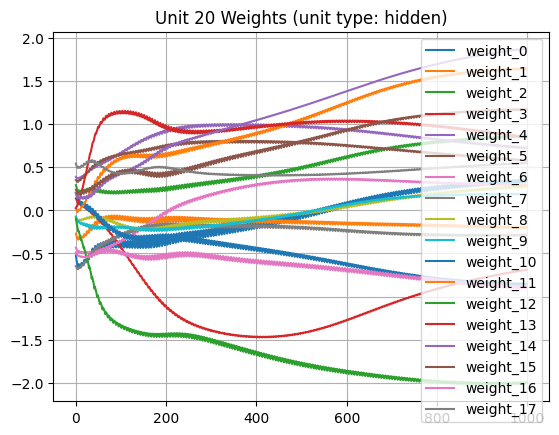

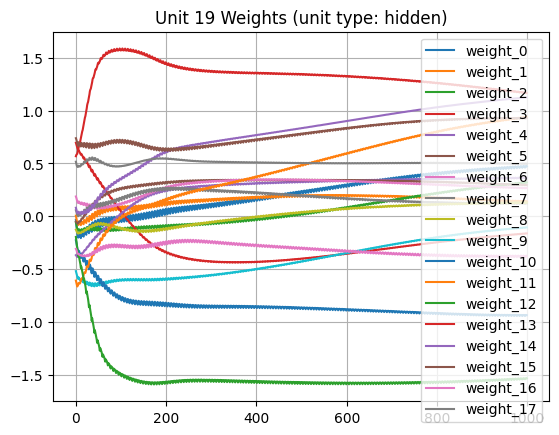

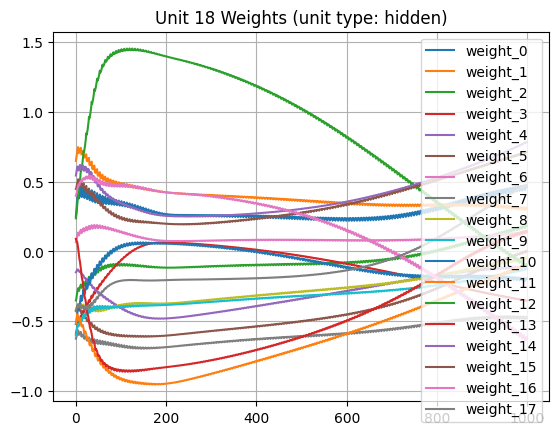

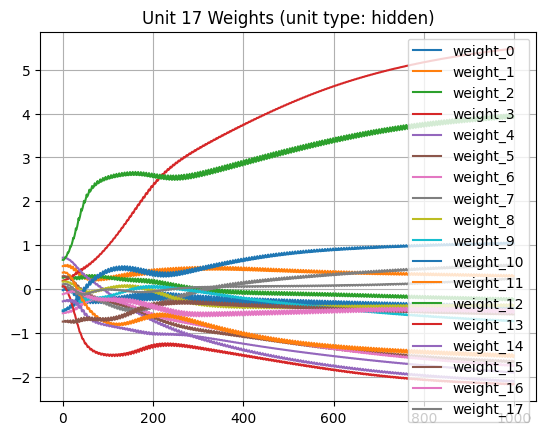

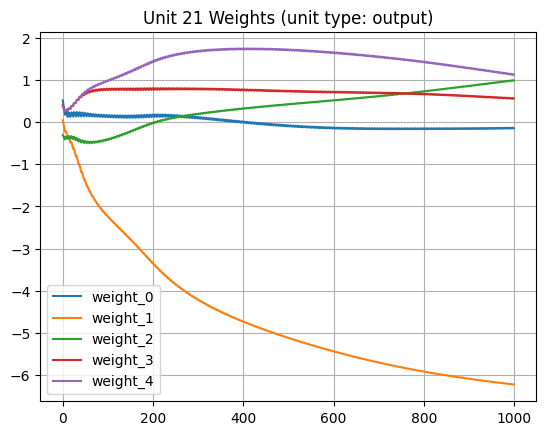

In [24]:
for unit_index in stats['units_weights'].keys():
    vals = np.array(stats['units_weights'][unit_index]).T
    multy_plot(vals, 
               ['weight_' + str(i) for i in range(len(vals))], 
               'Unit ' + str(unit_index) + ' Weights (unit type: ' + NN.neurons[unit_index].type + ')')

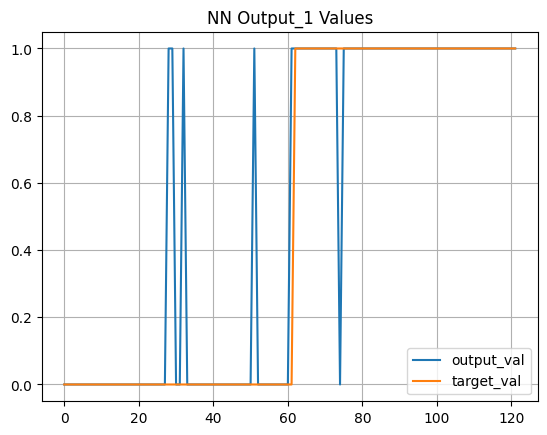

In [25]:
for i in range(TR_OUTPUT):
    sorted_order = training_set[:, TR_INPUT + i].argsort()
    multy_plot([tr_df['prediction_1'].values[sorted_order] , tr_df['output_1'].values[sorted_order]], 
                ['output_val', 'target_val'], 
                'NN Output_' + str(i + 1) +  ' Values')

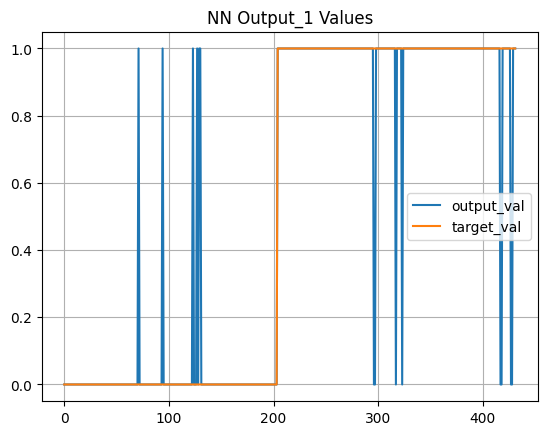

In [26]:
for i in range(TR_OUTPUT):
    sorted_order = validation_set[:, TR_INPUT + i].argsort()
    multy_plot([val_df['prediction_1'].values[sorted_order] , val_df['output_1'].values[sorted_order]], 
                ['output_val', 'target_val'], 
                'NN Output_' + str(i + 1) +  ' Values')